In [312]:
import pandas as pd
import qiime2 as q2
from q2_types.feature_data import DNAIterator, AlignedDNAFASTAFormat
import scipy
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import timeit

%matplotlib inline

In [240]:
def _evaluate_seqs(sequences, names, kmer_lengths=None, subsample_kmers=1.0):
    if not kmer_lengths:
        kmer_lengths = []
        
    rownames = ['Length ' + n for n in ['min', '1%', '25%', 'median', '75%', '99%', 'max']]
    rownames += ['N uniques', 'Sequences']
    rownames += ['%smer' % k for k in kmer_lengths]

    lengths = []
    results = pd.DataFrame(index=rownames)
    for n, seqs in zip(names, sequences):
        seqs = [str(s) for s in seqs]
        length_array = np.array([len(s) for s in seqs])
        lengths.append(length_array)
        len_quantiles = np.nanquantile(length_array, [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])
        uniqs = Counter(seqs).values()
        seq_entropy = scipy.stats.entropy(list(uniqs))
        res = list(len_quantiles) + [len(uniqs), seq_entropy]
        for k in kmer_lengths:
            if subsample_kmers < 1:
                subsample_size = int(subsample_kmers * len(seqs))
                seqs = np.random.choice(seqs, size=subsample_size, replace=False)
            vectorizer = HashingVectorizer(alternate_sign=False, analyzer='char', ngram_range=[k, k])
            X = vectorizer.fit_transform(seqs)
            kmer_freq = X.sum(axis=0)
            res.append(scipy.stats.entropy(kmer_freq, axis=1)[0])
        results[n] = res
    return results.round(2), lengths


def _plot_eval_seqs(results, lengths, names, palette):
    cmap = sns.color_palette(palette, len(names))

    # adjust figure width based on number of inputs — minimum 6 inches
    fig_width = max(6, 3 * len(lengths))
    fig = plt.figure(constrained_layout=True, figsize=(fig_width, 6))
    gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05, right=0.48, wspace=0.05)

    # length distribution histogram
    ax = fig.add_subplot(gs1[:-1, :])
    for dat, color in zip(lengths, cmap):
        sns.kdeplot(dat, shade=True, color=color, ax=ax, alpha=0.5)
    ax.set_title('Sequence Length Distribution')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Length (nt)')
    ax.set_xlim(results.loc['Length 1%'].min(), results.loc['Length 99%'].max())

    # boxplot of seq counts
    ax = fig.add_subplot(gs1[-1, :-2])
    sns.barplot(data=results.loc[['N uniques']], palette=palette, ax=ax)
    ax.set_title('N Unique Sequences')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

    # lineplot/boxplot of seq/kmer entropy
    ax = fig.add_subplot(gs1[-1, -2:])
    if len(results) > 9:
        sns.lineplot(data=results[8:], sort=False, palette=palette, ax=ax)
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    else:
        # plot boxplot if kmer entropy is not calculated
        sns.barplot(data=results.loc[['Sequences']], palette=palette, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    ax.set_title('Entropy')
    ax.set_ylabel('H')
    
    return fig



In [278]:
# test on greengenes data
seqs1=q2.Artifact.load('../../../ref_dbs/gg_13_8_otus/rep_set/97_otus.qza').view(DNAIterator)
seqs2=q2.Artifact.load('../../../ref_dbs/gg_13_8_otus/rep_set/99_otus.qza').view(DNAIterator)
seqs3=q2.Artifact.import_data('FeatureData[Sequence]',
                              '../../../ref_dbs/gg_13_8_otus/rep_set/91_otus.fasta').view(DNAIterator)

sequences = [seqs3, seqs1, seqs2]
names = ['gg_91', 'gg_97', 'gg_99']


In [156]:
# small test dataset
# seqs1 = ['ACTGATCGTGATGCTGATCGATGCTGATCGATCG',
#         'GTGTGTGAGTTATCGTGACGTGTAGCTGACGTAG',
#         'ACGTGTACTGTGACTGATGCTGACTGTGGTATAT',
#         'ACGAGTCTGAC',
#         'ACGTGTACGTGTAGCTGTAGC',
#         'CGTTGATGCTGTGATGCTACTGTGACTGATGCGTAGCGTAC']
# seqs2 = ['ACTGATCGTGATGCTGATCGATGCTGATCGATCG',
#         'AAAAAAAAAAAAAAAAAAAAAAA',
#         'AAAAAAAAAAAAAAAAAAAAAAAAAAAA']
# seqs3 = ['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
#         'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
#         'AAAAAAAAAAAAAAAAAAAAAAAAAAAA']
# sequences = [seqs1, seqs2, seqs3]
# names = ['seqs1', 'seqs2', 'seqs3']

In [279]:
kmer_lengths = [32, 16, 8]

start = timeit.default_timer()
results, lengths = _evaluate_seqs(sequences, names, kmer_lengths=kmer_lengths, subsample_kmers=0.2)
print('Runtime: {0}s'.format(str(timeit.default_timer() - start)))


Runtime: 100.76628460898064s


In [282]:
results

,gg_91,gg_97,gg_99
Length min,1258.00,1254.00,1254.00
Length 1%,1314.00,1312.00,1312.00
Length 25%,1384.00,1385.00,1383.00
Length median,1428.00,1433.00,1433.00
Length 75%,1481.00,1484.00,1483.00
Length 99%,1557.00,1549.00,1548.00
Length max,2353.00,2353.00,2368.00
N uniques,22090.00,99322.00,203452.00
Sequences,10.00,11.51,12.22
32mer,13.13,12.98,12.86


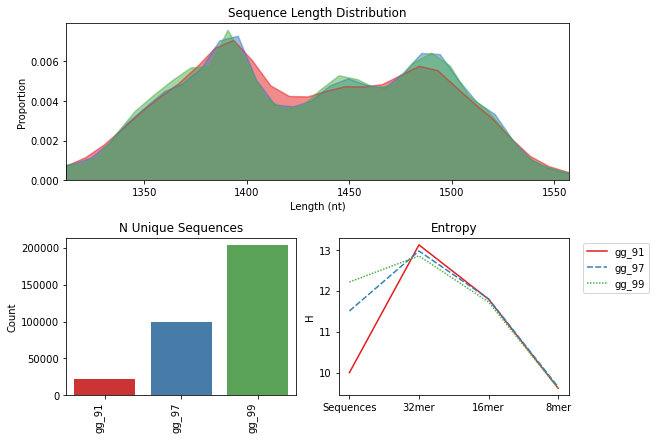

In [281]:
f = _plot_eval_seqs(lengths, names, palette)

# Subsampling benchmark

In [251]:
kmer_lengths = [32, 16, 8]

seqs2=q2.Artifact.load('../../../ref_dbs/gg_13_8_otus/rep_set/99_otus.qza')

grand_results = pd.DataFrame()
for subs in np.linspace(0.1,1,10):
    sequences = [seqs2.view(DNAIterator)]
    results, lengths = _evaluate_seqs(sequences, 
                                      names=[str(subs)],
                                      kmer_lengths=kmer_lengths,
                                      subsample_kmers=subs)
    grand_results = pd.concat([grand_results, results], axis=1)
grand_results


,0.1,0.2,0.30000000000000004,0.4,0.5,0.6,0.7000000000000001,0.8,0.9,1.0
Length min,1254.00,1254.00,1254.00,1254.00,1254.00,1254.00,1254.00,1254.00,1254.00,1254.00
Length 1%,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00
Length 25%,1383.00,1383.00,1383.00,1383.00,1383.00,1383.00,1383.00,1383.00,1383.00,1383.00
Length median,1433.00,1433.00,1433.00,1433.00,1433.00,1433.00,1433.00,1433.00,1433.00,1433.00
Length 75%,1483.00,1483.00,1483.00,1483.00,1483.00,1483.00,1483.00,1483.00,1483.00,1483.00
Length 99%,1548.00,1548.00,1548.00,1548.00,1548.00,1548.00,1548.00,1548.00,1548.00,1548.00
Length max,2368.00,2368.00,2368.00,2368.00,2368.00,2368.00,2368.00,2368.00,2368.00,2368.00
N uniques,203452.00,203452.00,203452.00,203452.00,203452.00,203452.00,203452.00,203452.00,203452.00,203452.00
Sequences,12.22,12.22,12.22,12.22,12.22,12.22,12.22,12.22,12.22,12.22
32mer,12.85,12.87,12.87,12.86,12.87,12.87,12.87,12.87,12.87,12.87


In [ ]:
grand_results.columns = ['subsample ' + str(round(float(c), 1)) for c in grand_results.columns]


[Text(0, 0, 'Sequences'),
 Text(1, 0, '32mer'),
 Text(2, 0, '16mer'),
 Text(3, 0, '8mer')]

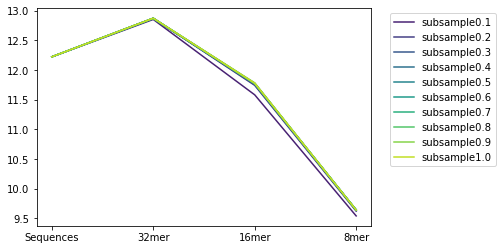

In [296]:
g = sns.lineplot(data=grand_results[8:], sort=False, dashes=False, palette='viridis')
g = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_title('Entropy')
ax.set_ylabel('H')
